# 経済・ファイナンスデータの計量時系列分析

* [Amazon](https://www.amazon.co.jp/gp/product/4254127928/ref=as_li_ss_tl?ie=UTF8&ref_=nav_ya_signin&&linkCode=ll1&tag=sankichi92-22&linkId=cda8aa8cd64ad2bda6a911e37a8c9ca1)
* [著者のページ](http://www.geocities.jp/tatsuyoshi_okimoto/books/tsa.html)

## 目次

1. [時系列分析の基礎概念](#1.-時系列分析の基礎概念)
2. [ARMA 過程](#2.-ARMA-過程)
3. 予測
4. [VAR モデル](#4.-VAR-モデル)

In [1]:
import numpy as np
from pandas import DataFrame, Series, read_excel
from statsmodels.tsa.api import stattools, AR, ARMA, VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
matplotlib.style.use('ggplot')

## 1. 時系列分析の基礎概念

###  1.3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1170b9ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119dad860>]], dtype=object)

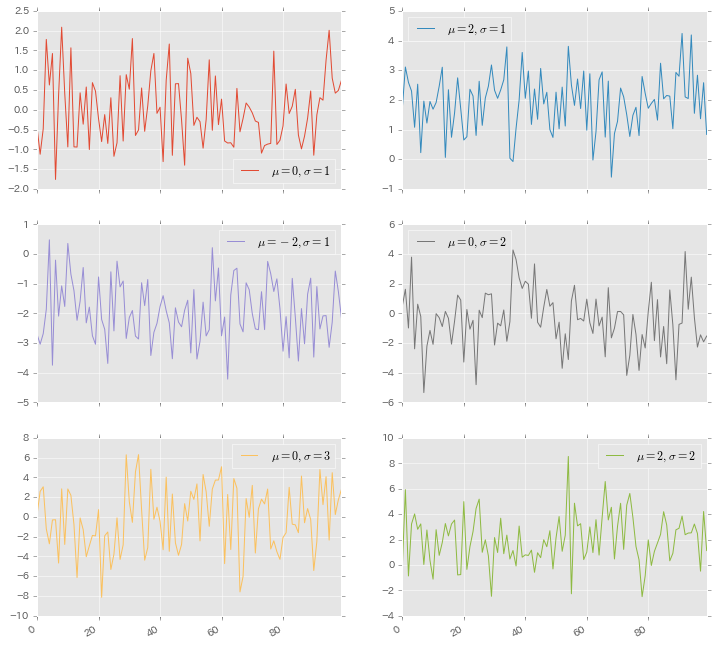

In [2]:
mu_sigma = [(0, 1), (2, 1), (-2, 1), (0, 2), (0, 3), (2, 2)]
white_noise = DataFrame()
for mu, sigma in mu_sigma:
    name = '$\mu={0}, \sigma={1}$'.format(mu, sigma)
    white_noise[name] = np.random.normal(mu, sigma, 100)
white_noise.plot(subplots=True, layout=(3,2), figsize=(12, 12))

### 1.5

In [3]:
eco = read_excel('http://www.geocities.jp/tatsuyoshi_okimoto/books/tsa/economicdata.xls', index_col='date')
eco.head()

,topix,exrate,indprod,cpi,saunemp,intrate
date,,,,,,
1975-01-01,276.09,29.13,47.33,52.625,1.7,12.67
1975-02-01,299.81,29.70,46.86,52.723,1.8,13.00
1975-03-01,313.50,29.98,46.24,53.114,1.8,12.92
1975-04-01,320.57,29.80,47.33,54.092,1.8,12.02
1975-05-01,329.65,29.79,47.33,54.385,1.8,11.06


#### (1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cc0ad68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cbd1b00>]], dtype=object)

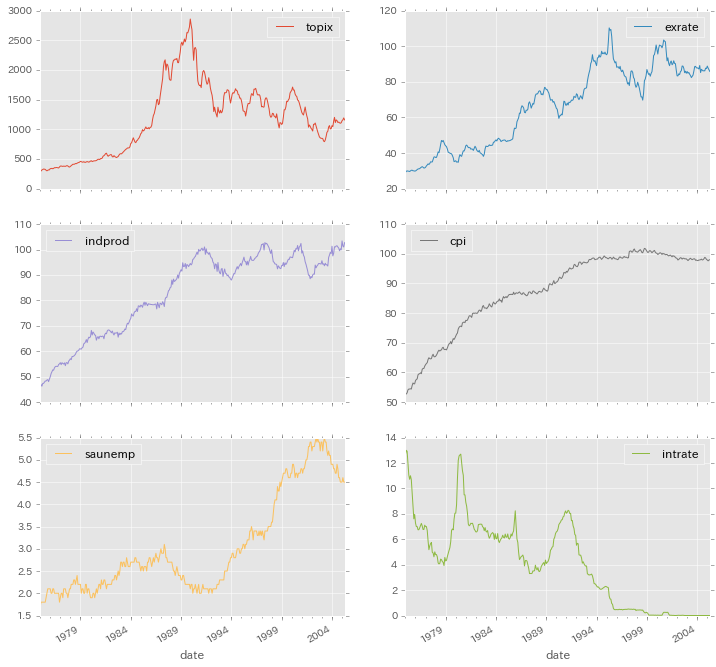

In [4]:
eco.plot(subplots=True, layout=(3,2), figsize=(12, 12))

#### (2)

In [5]:
eco_pct = np.log(eco).diff() * 100
eco_pct.head()

,topix,exrate,indprod,cpi,saunemp,intrate
date,,,,,,
1975-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-01,8.242204,1.937847,-0.997991,0.186050,5.715841,2.571236
1975-03-01,4.465042,0.938345,-1.331921,0.738875,0.000000,-0.617286
1975-04-01,2.230130,-0.602210,2.329912,1.824575,0.000000,-7.220457
1975-05-01,2.793082,-0.033563,0.000000,0.540208,0.000000,-8.323693


#### (3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bde3eb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11afd1470>], dtype=object)

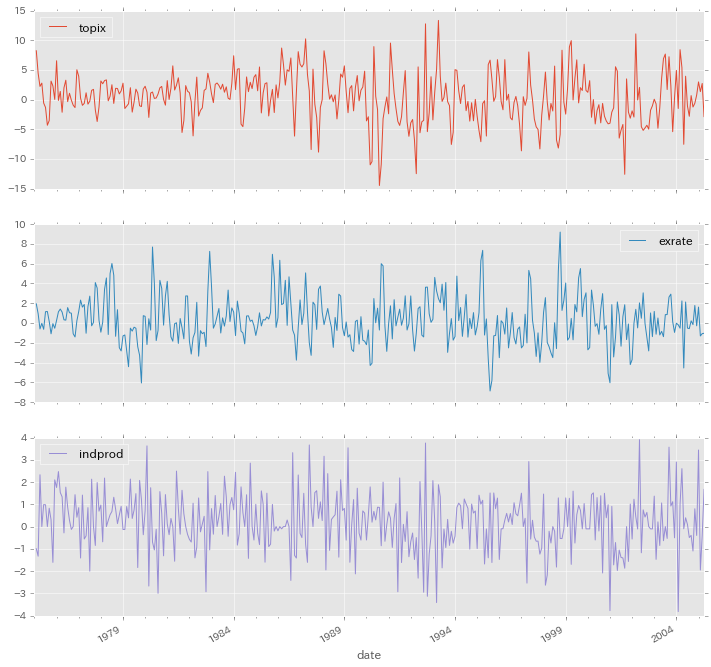

In [6]:
eco_pct[['topix', 'exrate', 'indprod']].plot(subplots=True, figsize=(12, 12))

#### (4)

In [7]:
indprod = eco_pct.indprod.dropna()

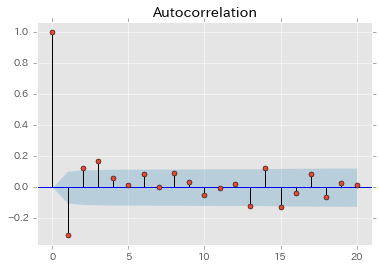

In [8]:
_ = plot_acf(indprod, lags=20)

In [9]:
def portmanteau_test(endog, lags=10):
    q_m, pvalues = acorr_ljungbox(endog, lags=lags)
    df = DataFrame([q_m.round(2), pvalues.round(3)], index=['Q(m)', 'p値'], columns=range(1, lags + 1))
    return df

In [10]:
portmanteau_test(indprod)

,1,2,3,4,5,6,7,8,9,10
Q(m),34.2,39.76,50.4,51.8,51.91,54.46,54.46,57.46,57.94,58.84
p値,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00


#### (5)

In [11]:
topix = eco_pct.topix.dropna()

In [12]:
portmanteau_test(topix)

,1,2,3,4,5,6,7,8,9,10
Q(m),34.68,36.39,36.84,38.55,38.91,39.87,39.97,40.2,44.42,45.97
p値,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [13]:
exrate = eco_pct.exrate.dropna()
portmanteau_test(exrate)

,1,2,3,4,5,6,7,8,9,10
Q(m),37.9,38.76,41.79,42.29,42.73,45.26,45.61,49.88,53.74,53.87
p値,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 2. ARMA 過程

### 2.5

#### (1)

In [14]:
ac = stattools.acf(indprod, nlags=20)
ac[0] = np.nan

In [15]:
pac = stattools.pacf(indprod, nlags=20)
pac[0] = np.nan

In [16]:
def plot_lines(axs):
    if isinstance(axs, np.ndarray):
        for ax in axs:
            plot_lines(ax)
    else:
        axs.axhline(0, color='k')
        axs.axhline(0.1, ls='--', color='k')
        axs.axhline(-0.1, ls='--', color='k')

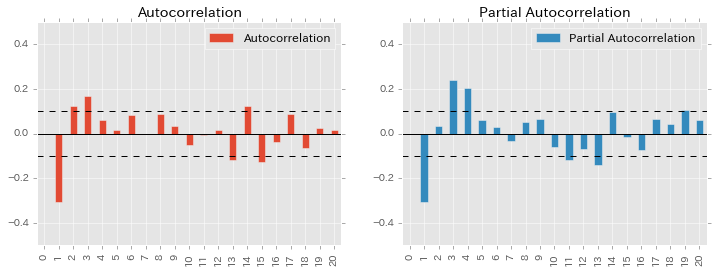

In [17]:
df = DataFrame({'Autocorrelation': ac, 'Partial Autocorrelation': pac})
axs = df.plot.bar(subplots=True, layout=(1,2), figsize=(12,4), ylim=(-0.5,0.5))
plot_lines(axs)

In [18]:
ar4 = AR(indprod).fit(maxlag=4)

In [19]:
ar4_ac = stattools.acf(ar4.resid, nlags=20)
ar4_ac[0] = np.nan

In [20]:
arma12 = ARMA(indprod, (1,2)).fit()

In [21]:
arma12_ac = stattools.acf(arma12.resid, nlags=20)
arma12_ac[0] = np.nan

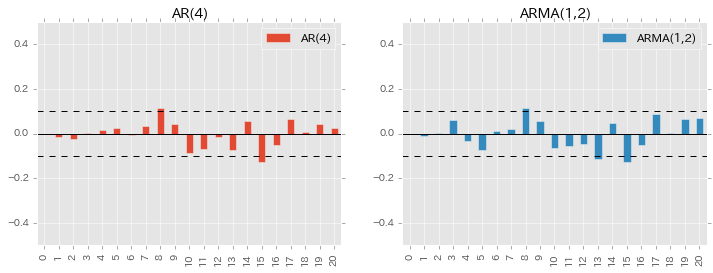

In [22]:
df = DataFrame({'AR(4)': ar4_ac, 'ARMA(1,2)': arma12_ac})
axs = df.plot.bar(subplots=True, layout=(1,2), figsize=(12,4), ylim=(-0.5,0.5))
plot_lines(axs)

In [23]:
def compare_arma_models(endog, orders):
    df = DataFrame(index=['AIC', 'SIC'])
    for order in orders:
        mod = ARMA(endog, order).fit()
        df[str(order)] = [round(mod.aic, 1), round(mod.bic, 1)]
    df['min'] = df.idxmin(axis=1)
    return df

In [24]:
orders = [(4,0), (0,3), (1,1), (2,1), (1,2), (2,2)]
compare_arma_models(indprod, orders)

,"(4, 0)","(0, 3)","(1, 1)","(2, 1)","(1, 2)","(2, 2)",min
AIC,1176.5,1179.2,1210.3,1193.1,1176.9,1181.8,"(4, 0)"
SIC,1199.8,1198.7,1225.9,1212.6,1196.4,1205.1,"(1, 2)"


#### (2)

In [25]:
portmanteau_test(ar4.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.07,0.290,0.290,0.410,0.650,0.670,1.140,6.020,6.78,9.480
p値,0.79,0.867,0.962,0.981,0.985,0.995,0.992,0.645,0.66,0.488


In [26]:
portmanteau_test(arma12.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.040,0.050,1.410,1.840,3.700,3.740,3.900,8.950,10.080,11.550
p値,0.833,0.973,0.704,0.764,0.594,0.712,0.791,0.346,0.344,0.317


### 2.6

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bc6bd68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ac05908>], dtype=object)

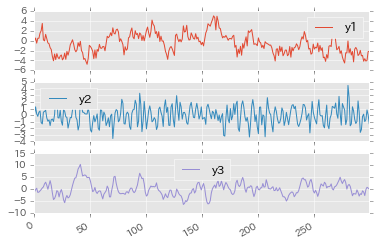

In [27]:
arma = read_excel('http://www.geocities.jp/tatsuyoshi_okimoto/books/tsa/arma.xls')
arma.plot(subplots=True)

#### (1)

In [28]:
y1 = arma.y1.values

In [29]:
def plot_acf_pacf(x, lags=20):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    plot_acf(x, ax=ax1, lags=lags)
    ax2 = fig.add_subplot(122)
    plot_pacf(x, ax=ax2, lags=lags)

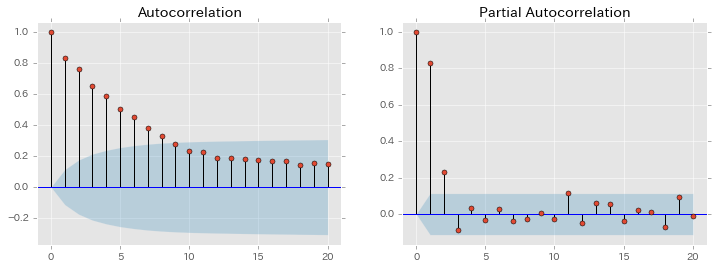

In [30]:
_ = plot_acf_pacf(y1)

#### (3)

In [31]:
order_select = stattools.arma_order_select_ic(y1, max_ar=2, max_ma=2,  ic=['aic', 'bic'])

In [32]:
order_select['aic']

,0,1,2
0,1271.814709,1108.776167,1007.319249
1,921.644359,910.287912,908.745588
2,907.184086,906.431071,908.288220


In [33]:
order_select['bic']

,0,1,2
0,1279.222274,1119.887515,1022.134379
1,932.755706,925.103042,927.264501
2,921.999216,924.949983,930.510915


In [34]:
print('AIC:', order_select['aic_min_order'], ', SIC:', order_select['bic_min_order'])

AIC: (2, 1) , SIC: (2, 0)


#### (4)

In [35]:
ar2 = AR(y1).fit(maxlag=2)

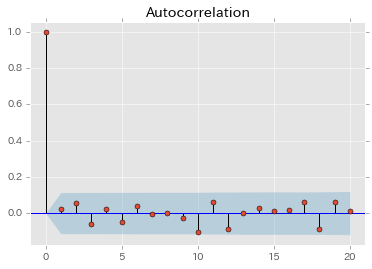

In [36]:
_ = plot_acf(ar2.resid, lags=20)

In [37]:
portmanteau_test(ar2.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.120,0.970,2.030,2.2,2.87,3.390,3.390,3.390,3.640,6.940
p値,0.727,0.614,0.566,0.7,0.72,0.759,0.846,0.907,0.933,0.731


In [38]:
arma21 = ARMA(y1, (2,1)).fit()

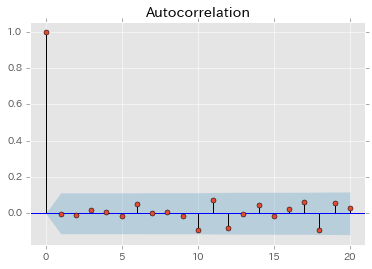

In [39]:
_ = plot_acf(arma21.resid, lags=20)

In [40]:
portmanteau_test(arma21.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.00,0.040,0.11,0.130,0.190,0.920,0.920,0.940,1.040,3.830
p値,0.96,0.982,0.99,0.998,0.999,0.989,0.996,0.999,0.999,0.955


#### (5)

In [41]:
y2 = arma.y2.values

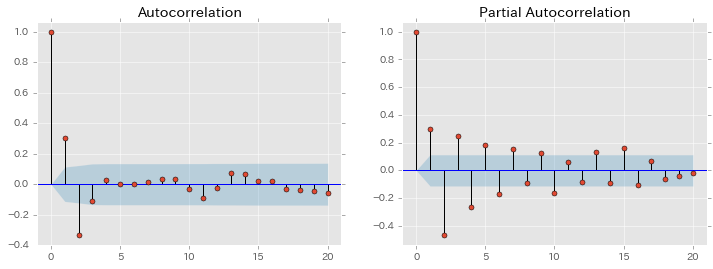

In [42]:
plot_acf_pacf(y2)

In [43]:
orders = [(0,2), (2,1), (2,2), (3,1), (3,2)]
compare_arma_models(y2, orders)

,"(0, 2)","(2, 1)","(2, 2)","(3, 1)","(3, 2)",min
AIC,855.2,832.6,834.5,834.6,835.7,"(2, 1)"
SIC,870.1,851.2,856.8,856.8,861.6,"(2, 1)"


In [44]:
arma21 = ARMA(y2, (2,1)).fit()

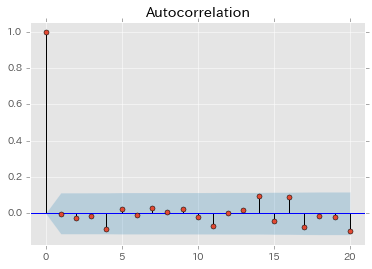

In [45]:
_ = plot_acf(arma21.resid, lags=20)

In [46]:
portmanteau_test(arma21.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.000,0.240,0.300,2.740,2.890,2.920,3.210,3.230,3.390,3.560
p値,0.981,0.889,0.961,0.602,0.717,0.819,0.865,0.919,0.947,0.965


In [47]:
y3 = arma.y3.values

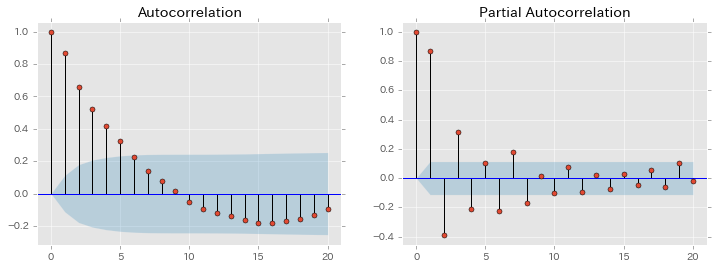

In [48]:
plot_acf_pacf(y3)

In [49]:
orders = [(4,0), (8,0), (1,1), (1,2), (1,3), (2,1), (2,2), (2,3)]
compare_arma_models(y3, orders)

,"(4, 0)","(8, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)",min
AIC,965.3,934.6,920.9,919.6,921.5,919.8,921.5,918.9,"(2, 3)"
SIC,987.5,971.6,935.8,938.1,943.7,938.3,943.7,944.8,"(1, 1)"


In [50]:
arma23 = ARMA(y3, (2,3)).fit()

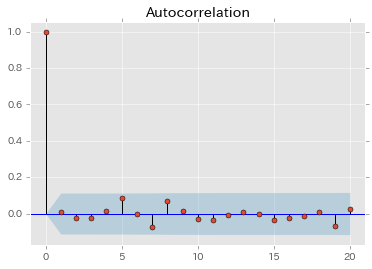

In [51]:
_ = plot_acf(arma23.resid, lags=20)

In [52]:
portmanteau_test(arma23.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),0.010,0.160,0.330,0.400,2.770,2.770,4.430,5.900,5.940,6.230
p値,0.911,0.922,0.954,0.983,0.736,0.837,0.729,0.658,0.746,0.795


In [53]:
arma11 = ARMA(y3, (1,1)).fit()

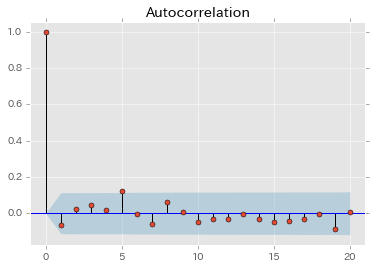

In [54]:
_ = plot_acf(arma11.resid, lags=20)

In [55]:
portmanteau_test(arma11.resid)

,1,2,3,4,5,6,7,8,9,10
Q(m),1.290,1.470,2.070,2.2,6.620,6.620,7.780,8.930,8.950,9.730
p値,0.255,0.479,0.558,0.7,0.251,0.357,0.352,0.348,0.442,0.465


## 4. VAR モデル

In [56]:
msci = read_excel('http://www.geocities.jp/tatsuyoshi_okimoto/books/tsa/msci_day.xls', index_col='Date')

### 4.5

#### (1)

In [57]:
msci_pct = np.log(msci).diff() * 100
msci_pct = msci_pct.dropna()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ab0b6d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ccfc4e0>]], dtype=object)

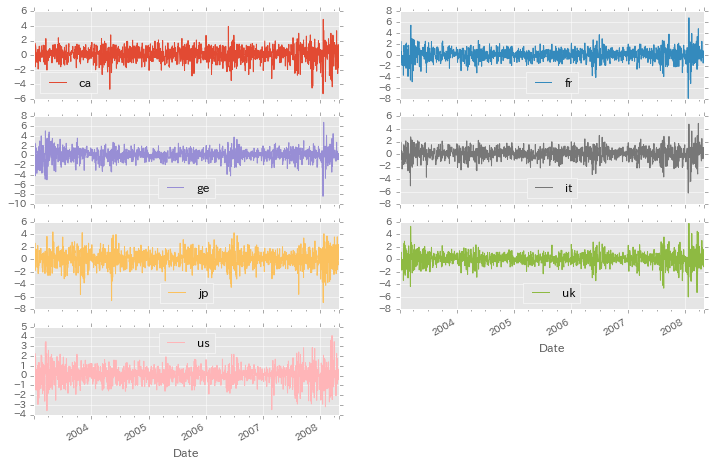

In [58]:
msci_pct.plot(subplots=True, layout=(4,2), figsize=(12,8))

In [59]:
jp_uk_us = ['jp', 'uk', 'us']

In [60]:
var3 = VAR(msci_pct[jp_uk_us]).fit(3)

In [61]:
df = DataFrame(index=['統計検定量', 'p値'])
for pair in itertools.permutations(jp_uk_us, r=2):
    col = pair[1] + ' → ' + pair[0]
    res = var3.test_causality(*pair, verbose=False)
    df[col] = [res['statistic'].round(3), res['pvalue'].round(3)]
df

,uk → jp,us → jp,jp → uk,us → uk,jp → us,uk → us
統計検定量,12.012,53.532,0.756,71.893,0.220,0.596
p値,0.000,0.000,0.519,0.000,0.882,0.617


/Users/miyoshi/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/Users/miyoshi/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


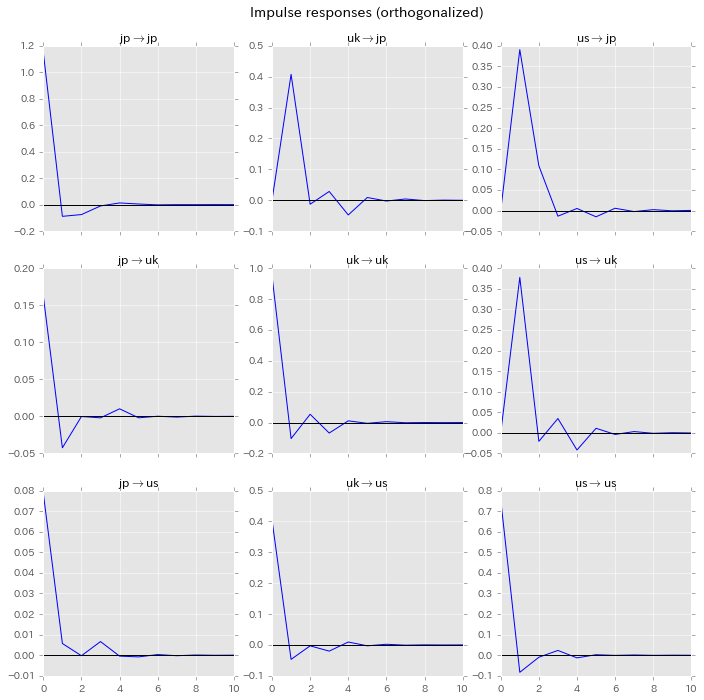

In [62]:
var3.irf().plot(orth=True, plot_stderr=False)

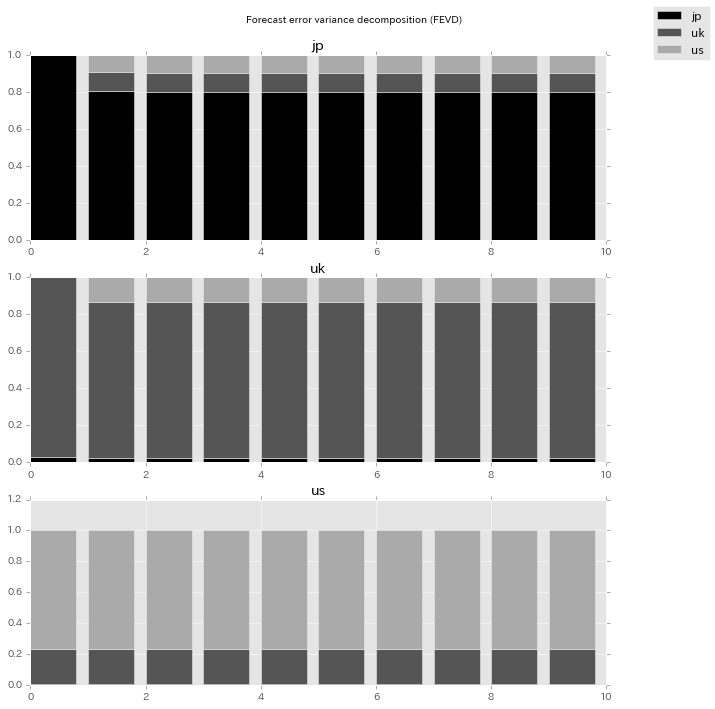

In [63]:
var3.fevd().plot()

### 4.6

#### (4)

In [64]:
mod = VAR(msci_pct[['jp', 'fr', 'ca']])

In [65]:
mod.select_order(10)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        0.4482       0.4596        1.566       0.4525
1        0.2412      0.2867*        1.273      0.2582*
2       0.2348*       0.3144       1.265*       0.2646
3        0.2372       0.3509        1.268       0.2797
4        0.2464       0.3942        1.279       0.3017
5        0.2460       0.4279        1.279       0.3141
6        0.2505       0.4665        1.285       0.3313
7        0.2554       0.5055        1.291       0.3489
8        0.2620       0.5462        1.300       0.3683
9        0.2659       0.5843        1.305       0.3850
10       0.2719       0.6244        1.313       0.4038
* Minimum



{'aic': 2, 'bic': 1, 'fpe': 2, 'hqic': 1}

In [66]:
res = mod.fit(maxlags=10, ic='aic')

#### (5)

In [67]:
res.test_causality('fr', 'jp')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         4.054051         2.997899            0.017  (2, 4143)
H_0: ['jp'] do not Granger-cause fr
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.9978994807918853,
 'df': (2, 4143),
 'pvalue': 0.017420829102524241,
 'signif': 0.05,
 'statistic': 4.0540505564677787}

In [68]:
res.test_causality('fr', 'ca')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
        20.899435         2.997899            0.000  (2, 4143)
H_0: ['ca'] do not Granger-cause fr
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.9978994807918853,
 'df': (2, 4143),
 'pvalue': 9.3104689429229201e-10,
 'signif': 0.05,
 'statistic': 20.899435247644277}

#### (6)

/Users/miyoshi/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/Users/miyoshi/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


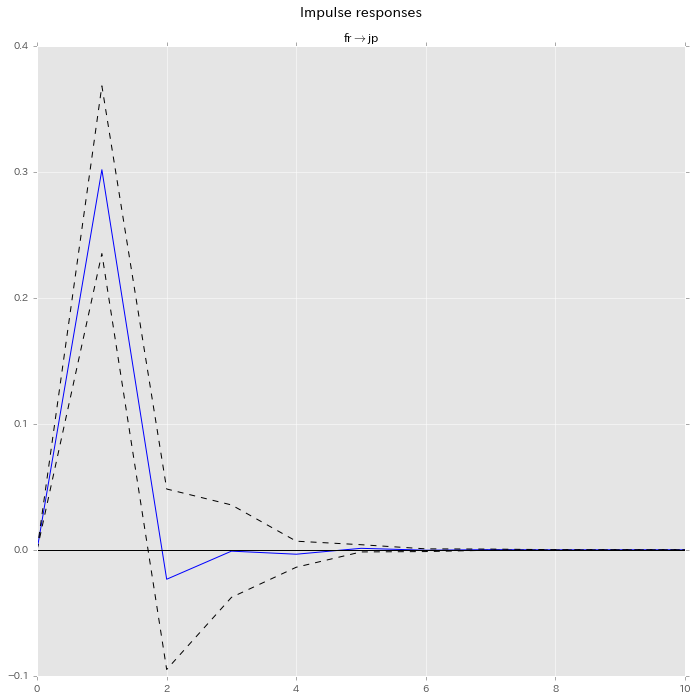

In [69]:
res.irf().plot(impulse='fr', response='jp')

#### (7)

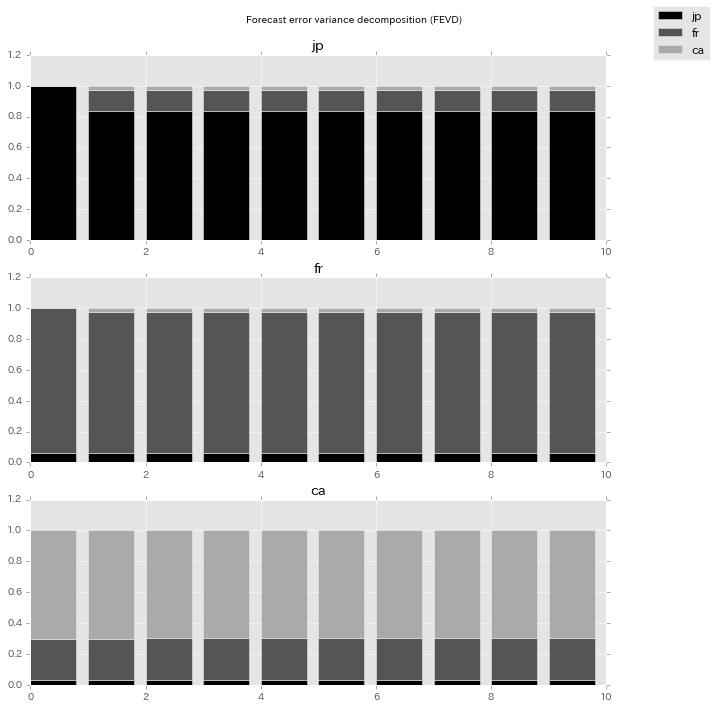

In [70]:
res.fevd().plot()